In [160]:
!pip install pubchempy requests rdkit-pypi shap lazypredict

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pubchempy import get_compounds
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Descriptors
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import seaborn as sns
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import shap

In [161]:
DataFrame = pd.read_csv('https://raw.githubusercontent.com/Riddars/ITMO_Project_Cytotoxic/main/Data/3.Cytotoxicity_(add%20SMILES).csv', encoding='ISO-8859-1')

Добавление дескрипторов (Евгений)

In [162]:
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
get_descriptors = rdMolDescriptors.Properties(descriptor_names)
num_descriptors = len(descriptor_names)

# Инициализация пустой матрицы для дескрипторов
descriptors_set = np.empty((0, num_descriptors), float)
smiles_list = []

# Замените DataFrame_CID на вашу переменную
for _, row in DataFrame.iterrows():
    smiles = row['Canonical Smiles']
    molecule = Chem.MolFromSmiles(smiles)

    if molecule is not None:
        descriptors = np.array(get_descriptors.ComputeProperties(molecule)).reshape((-1, num_descriptors))
        descriptors_set = np.append(descriptors_set, descriptors, axis=0)
        smiles_list.append(smiles)

# Создание DataFrame с дескрипторами и SMILES
df_descriptors = pd.DataFrame(descriptors_set, columns=descriptor_names)
df_descriptors['Canonical Smiles'] = smiles_list

# Объединение существующего датасета с новыми дескрипторами
DataFrame = pd.concat([DataFrame, df_descriptors], axis=1)
DataFrame_2 = pd.read_csv('https://raw.githubusercontent.com/Riddars/ITMO_Project_Cytotoxic/main/Descriptors/cell_line_descriptors.csv', encoding='ISO-8859-1')
# Выполните объединение по столбцам "Cell type" и "cell line"
DataFrame = DataFrame.merge(DataFrame_2, left_on="Cell type", right_on="cell line", how="inner")

Фильтрация данных (Аня)

In [163]:
# Фильтрация данных
DataFrame = DataFrame[DataFrame['viability (%)'] <= 150]
DataFrame = DataFrame[DataFrame['concentration (ug/ml)'] <= 1000]
DataFrame = DataFrame[DataFrame['Zeta potential (mV)'] >= -50]
DataFrame = DataFrame[DataFrame['Hydrodynamic diameter (nm)'] <= 400]

Визуализация распределения значений (Аня)

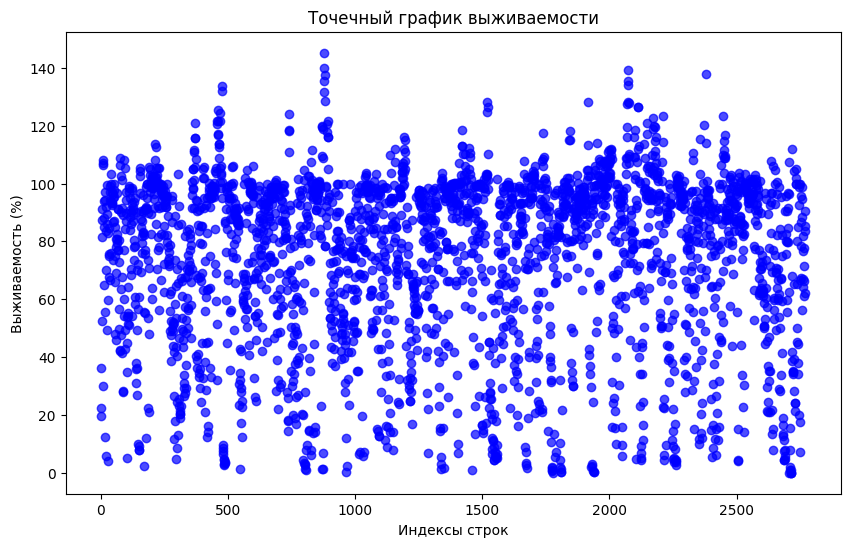

In [164]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(DataFrame['viability (%)'])), DataFrame['viability (%)'], color='blue', alpha=0.7)
plt.xlabel('Индексы строк')
plt.ylabel('Выживаемость (%)')
plt.title('Точечный график выживаемости')
plt.show()

In [165]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2772 entries, 0 to 2963
Data columns (total 61 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Cell type                        2772 non-null   object 
 1   test                             2772 non-null   object 
 2   material                         2772 non-null   object 
 3   time (hr)                        2772 non-null   int64  
 4   concentration (ug/ml)            2772 non-null   float64
 5   viability (%)                    2772 non-null   float64
 6   Hydrodynamic diameter (nm)       2772 non-null   float64
 7   Zeta potential (mV)              2772 non-null   float64
 8   CID                              2772 non-null   int64  
 9   Canonical Smiles                 2772 non-null   object 
 10  exactmw                          2772 non-null   float64
 11  amw                              2772 non-null   float64
 12  lipinskiHBA         

Удаляем дубликаты (Арсен)

In [166]:
# Список столбцов, которые нужно удалить
columns_to_drop = ['cell line', 'cell type', 'Canonical Smiles']

# Удаление столбцов
DataFrame = DataFrame.drop(columns_to_drop, axis=1)

Encoding (Арсен)

In [167]:
le = LabelEncoder()
text_data_features = ['Cell type', 'test', 'material', 'organism', 'morphology', 'tissue', 'disease']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in tqdm(text_data_features):
    DataFrame[i] = le.fit_transform(DataFrame[i])
    l3.append(list(DataFrame[i].unique())); l4.append(list(le.inverse_transform(DataFrame[i].unique())))
    print(i,' : ',DataFrame[i].unique(),' = ',le.inverse_transform(DataFrame[i].unique()))

Label Encoder Transformation


100%|██████████| 7/7 [00:00<00:00, 187.43it/s]

Cell type  :  [ 0  1  2  3  4  5  6  7  8  9 10 13 11 12 14 15 16 28 17 18 19 20 21 22
 29 31 30 23 64 24 25 65 66 26 27 32 33 34 35 36 37 38 39 44 40 41 42 67
 43 45 68 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]  =  ['143B' '16HBE' '95D' 'A2780' 'A431' 'A549' 'AGS' 'Ana-1' 'BALB/c3T3'
 'C3A' 'C6' 'Caco-2' 'CCL-110' 'CHO-K1' 'EBF' 'EJ28' 'H1299' 'HaCat'
 'HCMEC' 'HCT-116' 'HDF' 'HEBC3-KT' 'HEK' 'HEK293' 'HeLa' 'Hepatocytes'
 'HepG2' 'HFL1' 'hFOB1.19' 'HGF' 'HK-2' 'hMSC' 'hPDLF' 'HT29' 'HUVEC'
 'IMR90' 'J774A.1' 'Jurkat' 'KEC' 'L-02' 'L-132' 'L929' 'Lymphocyte'
 'Macrophages' 'MCF-7' 'MDCK' 'MDCK-II' 'mDF' 'MG-63' 'Monocytes'
 'neuro2A' 'NHDF' 'NIH3T3' 'NR8383' 'PBMC' 'PC12' 'PK-15' 'RAW264.7'
 'RFPEC' 'SHSY5Y' 'SIRC' 'SKOV-3' 'THP-1' 'U87' 'UM-UC-3' 'V79' 'VERO'
 'WA09' 'WISH']
test  :  [ 9 10  1  3  8  7 11  0  4 12  2  6  5]  =  ['MTT' 'NRU' 'CCK-8' 'CellTiterBlue' 'MTS' 'Live/Dead' 'WST-1'
 'AlamarBlue' 'CellTiterGlo' 'XTT' 'CVS' 'LDH' 'CytoTox-Glo']
material  :  [ 1  9 

Нормализация (Арсен)



In [168]:
# Ваши данные и столбцы для нормализации
columns_to_normalize = ['time (hr)', 'concentration (ug/ml)', 'viability (%)', 'Hydrodynamic diameter (nm)', 'Zeta potential (mV)', 'CID', 'exactmw', 'amw', 'lipinskiHBA', 'lipinskiHBD', 'NumRotatableBonds', 'NumHBD', 'NumHBA', 'NumHeavyAtoms', 'NumAtoms', 'NumHeteroatoms', 'NumAmideBonds', 'FractionCSP3', 'NumRings', 'NumAromaticRings', 'NumAliphaticRings', 'NumSaturatedRings', 'NumHeterocycles', 'NumAromaticHeterocycles', 'NumSaturatedHeterocycles', 'NumAliphaticHeterocycles', 'NumSpiroAtoms', 'NumBridgeheadAtoms', 'NumAtomStereoCenters', 'NumUnspecifiedAtomStereoCenters', 'labuteASA', 'tpsa', 'CrippenClogP', 'CrippenMR', 'chi0v', 'chi1v', 'chi2v', 'chi3v', 'chi4v', 'chi0n', 'chi1n', 'chi2n', 'chi3n', 'chi4n', 'hallKierAlpha', 'kappa1', 'kappa2', 'kappa3', 'Phi', 'BSL']

# Получите минимальные и максимальные значения для каждого столбца до нормализации
min_values_before = DataFrame[columns_to_normalize].min()
max_values_before = DataFrame[columns_to_normalize].max()

Обучение модели RF для оценки важности дескрипторов

R-квадрат: 0.74
MSE: 237.31


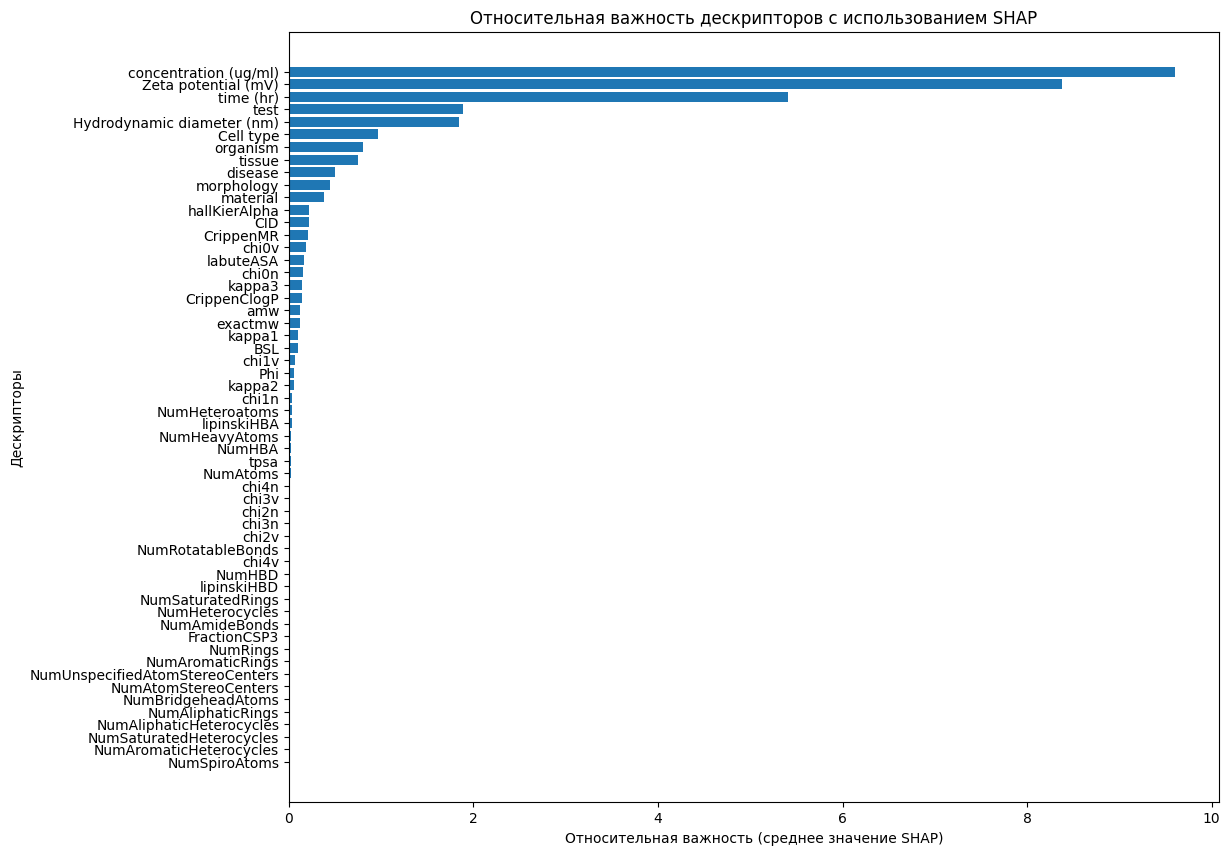

In [169]:
X = DataFrame.drop(['viability (%)'], axis=1)
y = DataFrame['viability (%)']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация модели
model = RandomForestRegressor()

# Обучение модели
model.fit(X_train, y_train)

# Оценка R-квадрат и MSE на тестовых данных
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Вывод значений R-квадрат и MSE
print(f'R-квадрат: {r2:.2f}')
print(f'MSE: {mse:.2f}')

# Инициализация explainer SHAP для модели
explainer = shap.TreeExplainer(model)

# Получение значений SHAP для тестовых данных
shap_values = explainer.shap_values(X_test)

# Определение важности дескрипторов
importance = abs(shap_values).mean(axis=0)

# Создание DataFrame с важностью дескрипторов
importance_df = pd.DataFrame({
    'Descriptor': X.columns,
    'Importance': importance
})

# Сортировка по убыванию важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Построение графика относительной важности дескрипторов
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Descriptor'], importance_df['Importance'])
plt.xlabel('Относительная важность (среднее значение SHAP)')
plt.ylabel('Дескрипторы')
plt.title('Относительная важность дескрипторов с использованием SHAP')
plt.gca().invert_yaxis()
plt.show()

Удаление лишних дескрипторов

In [170]:
# Список столбцов, которые нужно удалить
columns_to_drop = ['chi4n', 'tpsa', 'chi3v', 'chi2n', 'NumRotatableBonds', 'chi4v', 'chi3n', 'chi2v', 'NumHBD', 'lipinskiHBD', 'NumAromaticRings', 'NumAliphaticRings', 'NumAmideBonds', 'FractionCSP3', 'NumUnspecifiedAtomStereoCenters', 'NumAtomStereoCenters', 'NumRings', 'NumAliphaticHeterocycles', 'NumSaturatedHeterocycles', 'NumAromaticHeterocycles', 'NumHeterocycles', 'NumSaturatedRings', 'NumSpiroAtoms']

# Удаление столбцов
DataFrame = DataFrame.drop(columns_to_drop, axis=1)

LazyRegressor для выбора наилучшей модели

100%|██████████| 42/42 [00:14<00:00,  2.87it/s]


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 2217, number of used features: 32
[LightGBM] [Info] Start training from score 74.094124
                               Adjusted R-Squared          R-Squared  \
Model                                                                  
ExtraTreesRegressor                          0.75               0.77   
XGBRegressor                                 0.74               0.76   
RandomForestRegressor                        0.71               0.73   
BaggingRegressor                             0.71               0.73   
HistGradientBoostingRegressor                0.71               0.72   
LGBMRegressor                                0.70               0.72   
GradientBoosting

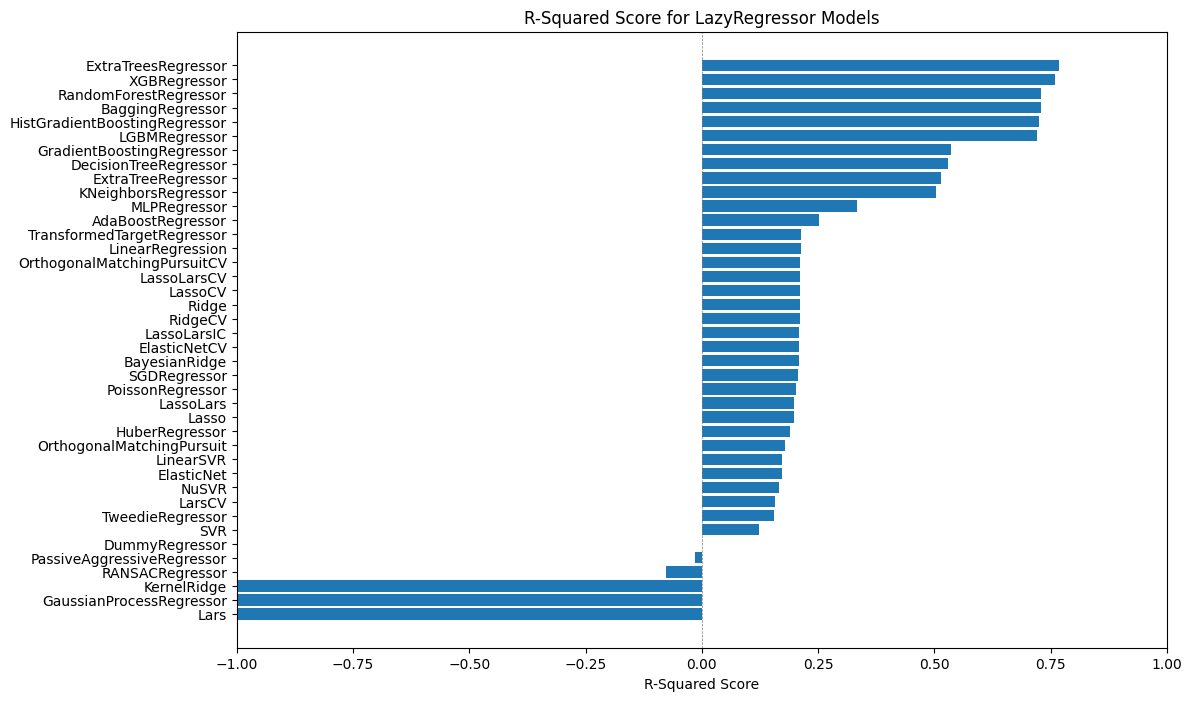

In [171]:
# Разделение на признаки и целевую переменную
X = DataFrame.drop('viability (%)', axis=1)
y = DataFrame['viability (%)']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение моделей регрессии
reg = LazyRegressor(predictions=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Вывод результатов
print(models)

# Построение более наглядного графика
plt.figure(figsize=(12, 8))
plt.barh(models.index, models['R-Squared'])
plt.xlabel('R-Squared Score')
plt.title('R-Squared Score for LazyRegressor Models')
plt.axvline(x=0.0, color='gray', linestyle='--', linewidth=0.5)  # Добавление вертикальной линии на 0
plt.xlim(-1.0, 1.0)  # Установка пределов для x-оси
plt.gca().invert_yaxis()
plt.show()

Функция для визуализации распределения предсказанных значений и фактических

In [172]:
def plot_predicted_vs_actual(y_test, y_pred):
    # Создание фигуры и осей
    fig, ax = plt.subplots()

    # Построение точечного графика с фактическими значениями по оси x
    ax.scatter(y_test, y_pred, color='red', label='Predicted', marker='o', s=30)
    ax.scatter(y_test, y_test, color='blue', label='Actual', marker='x', s=30)

    # Добавление линии идентичности (y = x)
    ax.plot(y_test, y_test, color='green', linestyle='--', label='Identity Line')

    # Настройка осей и легенды
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title('Scatter Plot of Predicted vs. Actual Values')
    ax.legend()

    # Оценка качества модели
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Среднеквадратичная ошибка (MSE):", mse)
    print("Коэффициент детерминации (R^2):", r2)

    # Отображение графика
    plt.show()

R-квадрат: 0.7372928849015972
MSE: 238.75376131124492
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
R-квадрат: 0.7392761054643057
MSE: 236.95136867837272
Среднеквадратичная ошибка (MSE): 236.95136867837272
Коэффициент детерминации (R^2): 0.7392761054643057


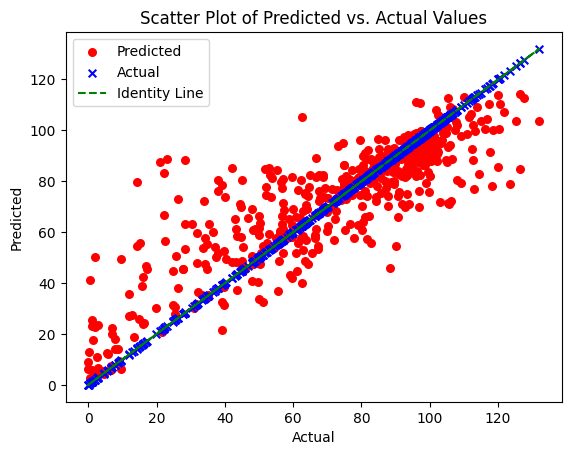

In [173]:
X = DataFrame.drop(['viability (%)'], axis=1)
y = DataFrame['viability (%)']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация модели
model = RandomForestRegressor()

# Обучение модели
model.fit(X_train, y_train)

# Оценка R-квадрат и MSE на тестовых данных
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Вывод значений R-квадрат и MSE
print('R-квадрат:', r2)
print('MSE:', mse)

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],

}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

model = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                     min_samples_split=best_params['min_samples_split'],
                     max_depth=best_params['max_depth'],
                     )

# Обучение модели на обучающей выборке с оптимальными параметрами
model.fit(X_train, y_train)

# Предсказание на тестовой выборке с оптимальными параметрами
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Вывод значений R-квадрат и MSE
print('R-квадрат:', r2)
print('MSE:', mse)

plot_predicted_vs_actual(y_test, y_pred)

Среднеквадратичная ошибка (MSE): 219.4946947094006
Коэффициент детерминации (R^2): 0.7584841482294358
Среднеквадратичная ошибка (MSE): 219.4946947094006
Коэффициент детерминации (R^2): 0.7584841482294358


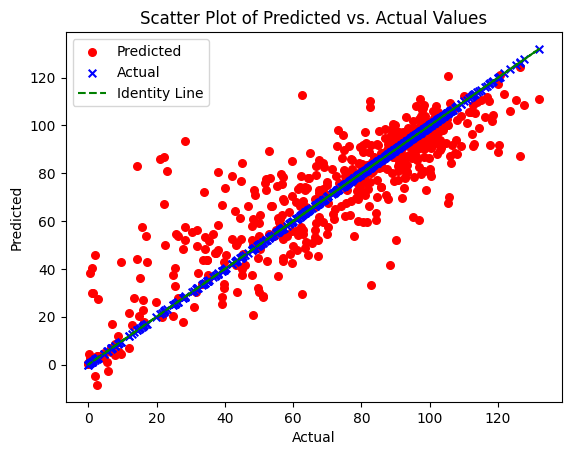

In [174]:
# Загрузите данные и разделите их на обучающий и тестовый наборы
X = DataFrame.drop('viability (%)', axis=1)
y = DataFrame['viability (%)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создайте и обучите модель XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)

# Получите предсказания на тестовом наборе
y_pred = model.predict(X_test)

# Оцените качество модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Среднеквадратичная ошибка (MSE):", mse)
print("Коэффициент детерминации (R^2):", r2)
plot_predicted_vs_actual(y_test, y_pred)

Среднеквадратичная ошибка (MSE): 250.79791911463033
Коэффициент детерминации (R^2): 0.724040377661753
Среднеквадратичная ошибка (MSE): 250.79791911463033
Коэффициент детерминации (R^2): 0.724040377661753


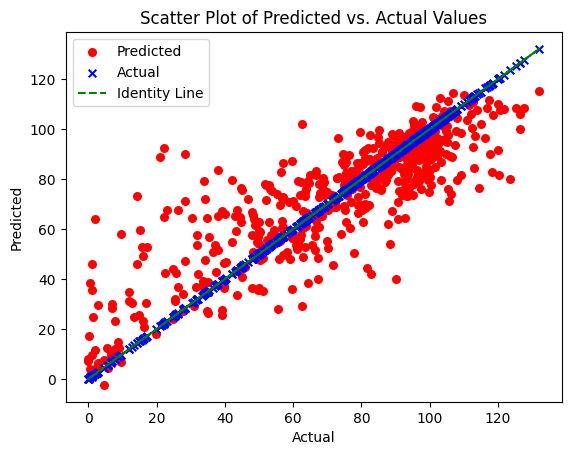

In [175]:
X = DataFrame.drop('viability (%)', axis=1)
y = DataFrame['viability (%)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создайте и обучите модель HistGradientBoostingRegressor
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Получите предсказания на тестовом наборе
y_pred = model.predict(X_test)

# Оцените качество модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Среднеквадратичная ошибка (MSE):", mse)
print("Коэффициент детерминации (R^2):", r2)
plot_predicted_vs_actual(y_test, y_pred)

Доп. Визуализация

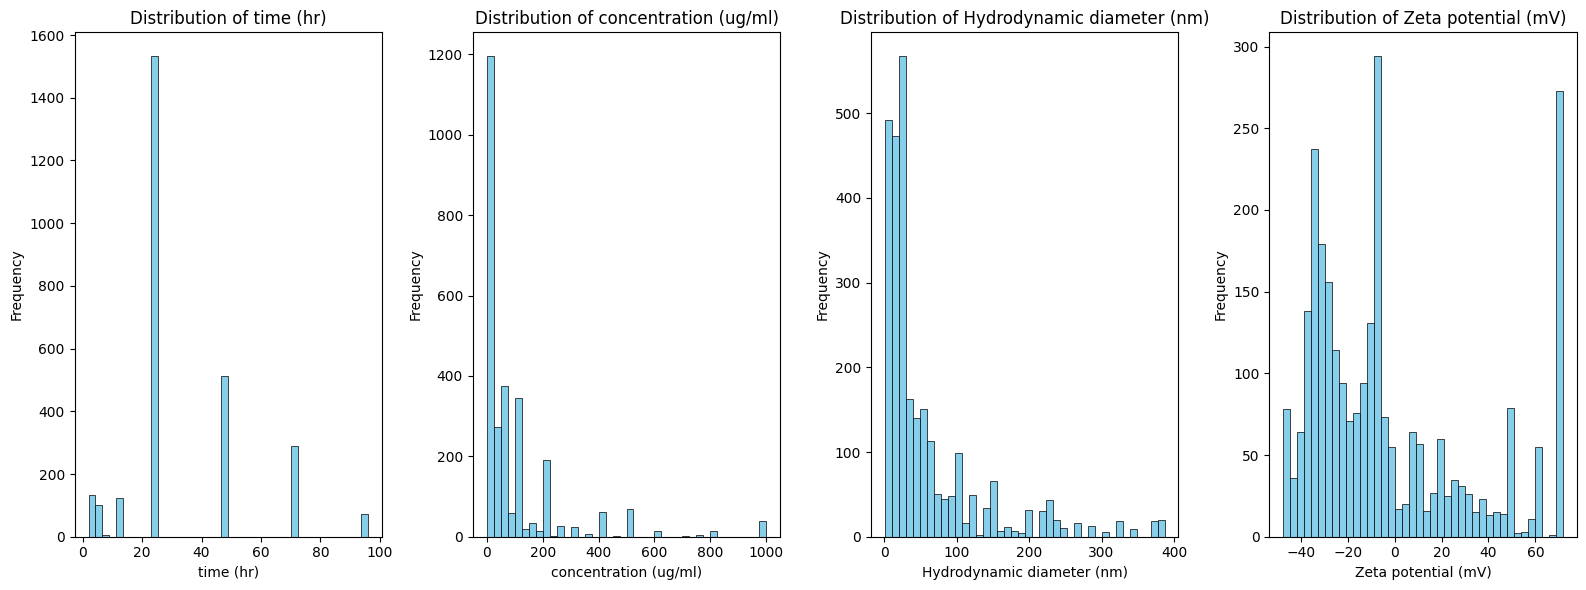

In [176]:
# Столбцы, для которых нужно создать графики
columns_to_plot = ['time (hr)', 'concentration (ug/ml)', 'Hydrodynamic diameter (nm)', 'Zeta potential (mV)']

# Создайте одну большую фигуру для все графики
plt.figure(figsize=(16, 6))

# Создайте гистограмму для каждого столбца
for i, column_name in enumerate(columns_to_plot):
    plt.subplot(1, 4, i+1)  # 1 строка, 3 столбца, i+1 - индекс текущего графика
    n, bins, patches = plt.hist(DataFrame[column_name], bins=40, color='skyblue', edgecolor='black', lw=0.5)
    for patch in patches:
        patch.set_linewidth(0.5)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')

try:
    plt.savefig('C:\\MyProject\\ITMO_Project_Cytotoxic\\histogram_plot.png')
except Exception as e:
    print(f"Ошибка при сохранении файла: {e}")

# Отобразите все графики
plt.tight_layout()
plt.show()